IBM-UTokyo 量子コンピューティング・駒場スクール
# 量子テレポーテーション


Kifumi Numata, IBM Quantum, Sep 29 2025 </br>
© 2025 International Business Machines Corporation

In [1]:
# Google Colabで実行している方は以下の # を取り除いてインストールを実行してくださう

#!pip install 'qiskit[visualization]' qiskit-ibm-runtime qiskit-aer

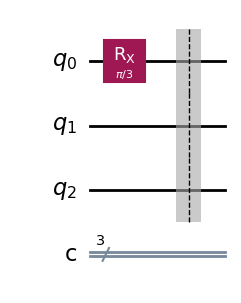

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)    

# Aliceのもつ暗号の量子状態ψを今回はRxで作ります
qc.rx(np.pi/3,0)
qc.barrier()    #回路を見やすくするために入れます

# 回路を描画
qc.draw(output="mpl")

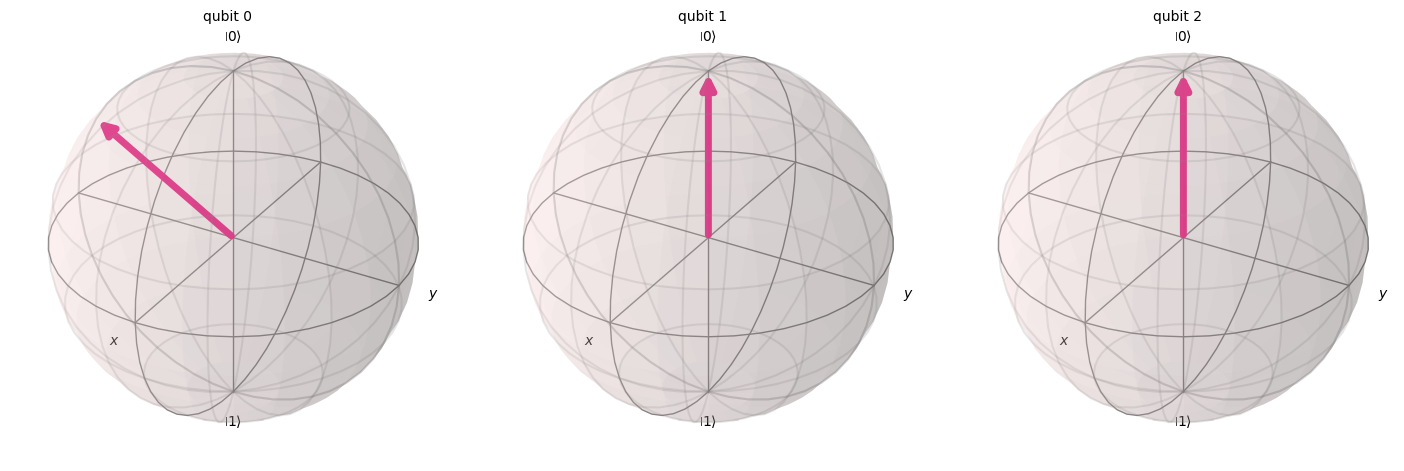

In [2]:
from qiskit_aer import StatevectorSimulator
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector() # set shots = 1

from qiskit.visualization import plot_bloch_multivector
plot_bloch_multivector(out_vector)

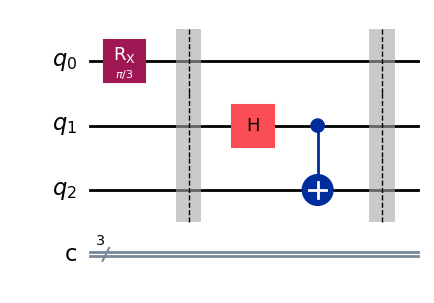

In [3]:
# 量子もつれを作ります
qc.h(1)
qc.cx(1, 2)
qc.barrier()    #回路を見やすくするために入れます

# 回路を描画
qc.draw(output="mpl")

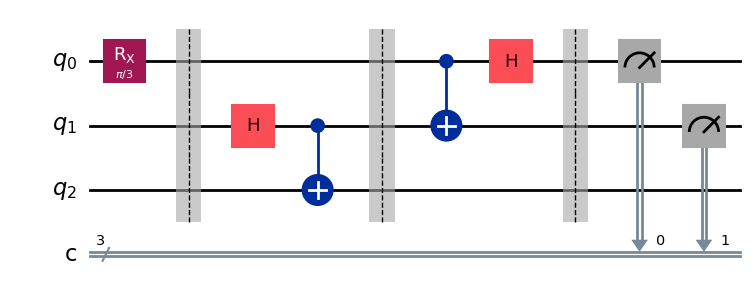

In [4]:
# AliceがCNOTとHで、自分の量子ビット2つをエンタングルさせ測定します。
qc.cx(0, 1)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

# 回路を描画
qc.draw(output="mpl")

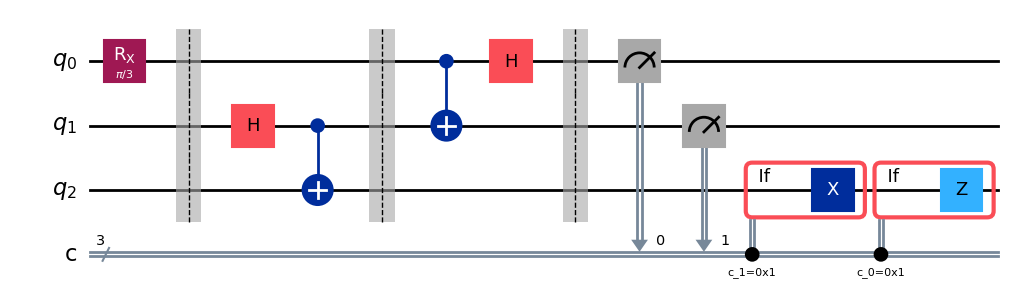

In [5]:
#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
with qc.if_test((1, 1)): # 古典レジスター1の値が1だったらXゲートをq2にかける
    qc.x(2)
with qc.if_test((0, 1)): # 古典レジスター0の値が1だったらZゲートをq2にかける
    qc.z(2)
    
qc.draw(output="mpl")

量子テレポーテーション回路が完成しました。qubit2にqubit0の量子状態($R_x(\pi/3)$)が転送されていることを確認しましょう。

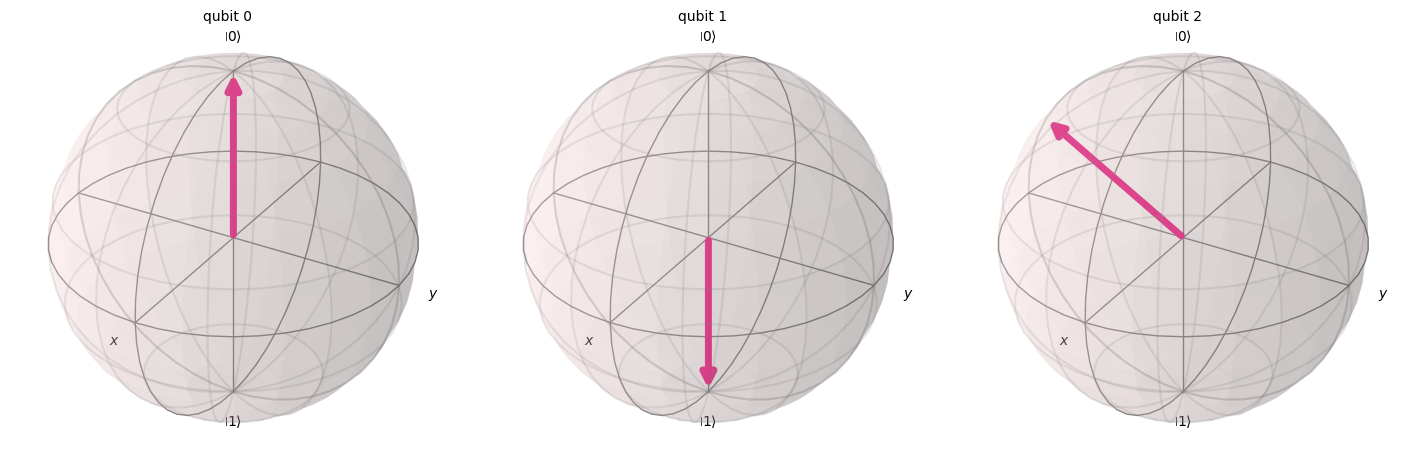

In [6]:
backend = StatevectorSimulator()
out_vector = backend.run(qc,shots=1).result().get_statevector()

plot_bloch_multivector(out_vector)

Bobに暗号の量子状態が転送されたことを確認するために、最後にBobの量子ビットに逆向きのX軸回転を適用して、シミュレーターで実験し、測定結果が0になることを確認します。

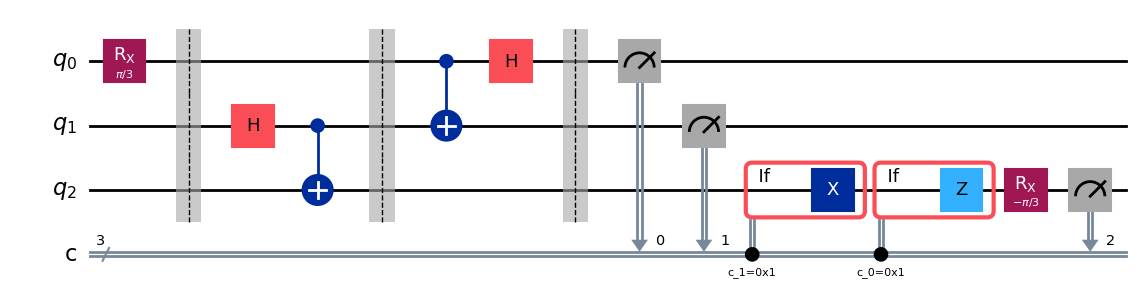

In [7]:
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)  

# Aliceのもつ未知の量子状態ψをRxで作ります。角度はπ/3にしました。
qc.rx(np.pi/3,0)
qc.barrier()    #回路を見やすくするために入れます

# 量子もつれを作ります
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# AliceがCNOTとHで自分の量子ビット2つをエンタングルさせ測定します。
qc.cx(0, 1)
qc.h(0)
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
with qc.if_test((1, 1)): # 古典レジスター1の値が1だったらXゲートをq2にかける
    qc.x(2)
with qc.if_test((0, 1)): # 古典レジスター0の値が1だったらZゲートをq2にかける
    qc.z(2)

# 未知の量子状態ψの逆ゲートをかけて０が測定できるか確かめます
qc.rx(-np.pi/3, 2)    
qc.measure(2, 2)

qc.draw(output="mpl")

{'010': 247, '001': 252, '011': 261, '000': 264}


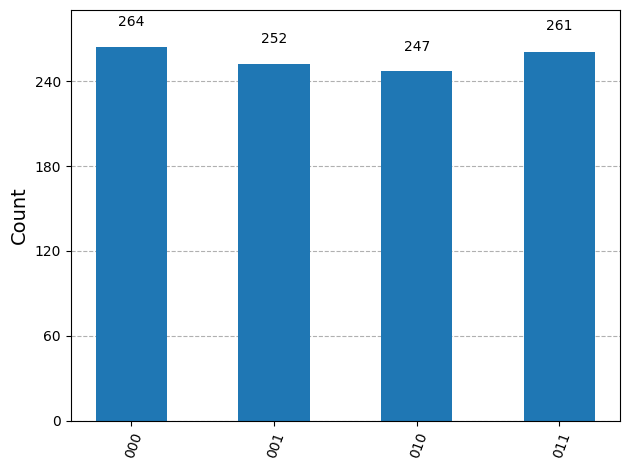

In [8]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2
from qiskit.visualization import plot_histogram

# シミュレーターで実験
backend = AerSimulator()

# Samplerで実行
sampler = SamplerV2(backend)
job = sampler.run([qc])
result = job.result()


#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram(counts)

qiskitのビット配列は右端が0なので、Bobのビット(qubit 2)は左端です。左端のビットが全て0になっていることが確認できましたか？

## 実デバイスでの実行

実デバイスで上記の実験を行ってみましょう。先程の演習と同じように、次のセルの `your_api_key` と `your_crn` を上書きして実行します。

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

service = QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token=your_api_key, 
    instance=your_crn, 
    set_as_default=True, 
    overwrite=True,
)

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]

In [11]:
# 以下でデバイスを指定できます。
backend = service.backend('ibm_brisbane') 

In [12]:
#一番空いているバックエンドを自動的に選択することもできます
backend = service.least_busy(operational=True)
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  <IBMBackend('ibm_brisbane')>


実行途中で回路を測定し、その結果をもとにさらに実行を続けるための操作がない場合は、バックエンドに追加します。

In [13]:
if "if_else" not in backend.target.operation_names:
    backend.target.add_instruction(IfElseOp, name="if_else")

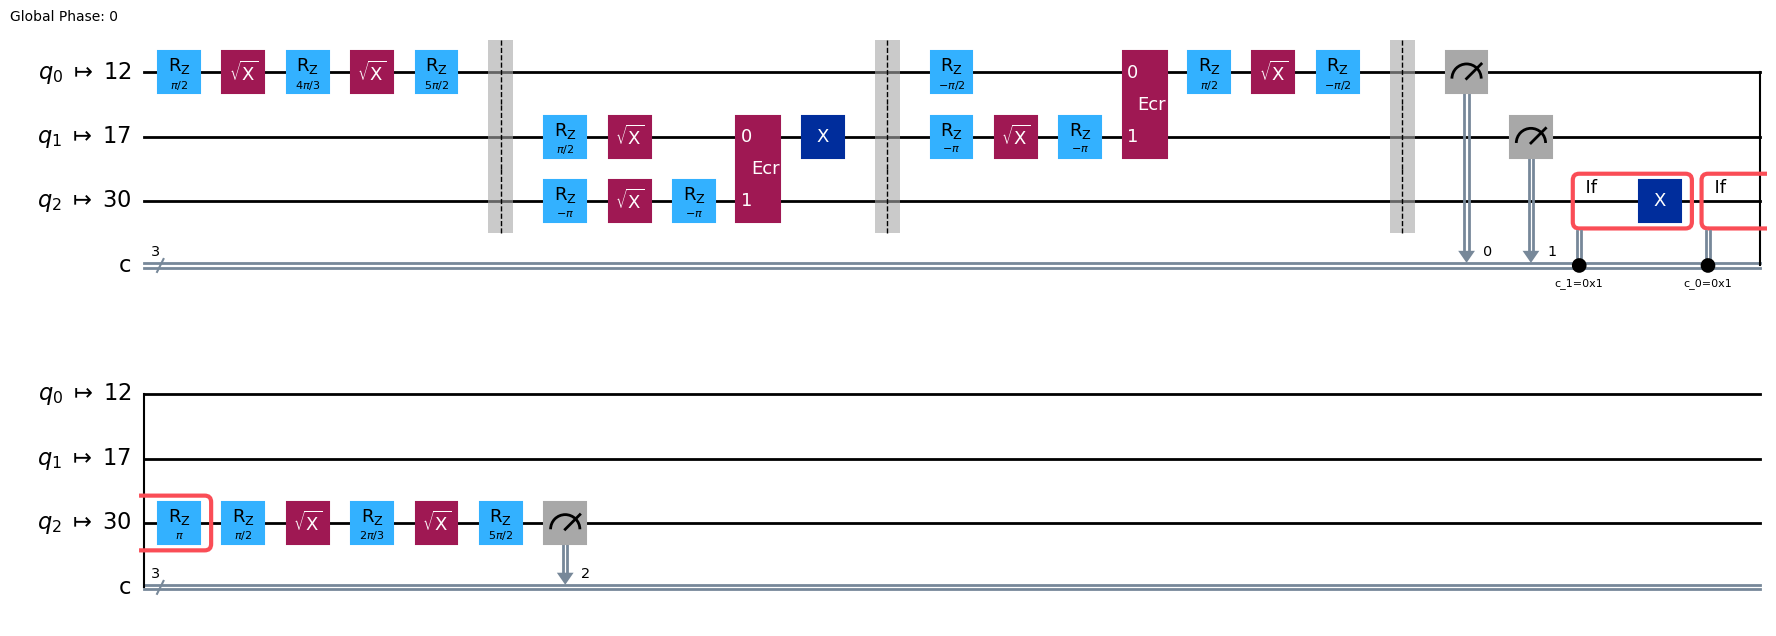

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# 回路を実機のバックエンドでの実行に最適な回路に変換します
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [15]:
# Samplerで実行します
sampler = SamplerV2(backend)
# 最新の動的回路を使うためにパスを設定します
sampler.options.experimental = {"execution_path" : "gen3-experimental"}
job = sampler.run([isa_circuit])

print("job id:", job.job_id()) # job idの確認

job id: d3b5fqmdacis73d9lau0


In [17]:
# ジョブの実行状態を確認します
job = service.job(job.job_id()) 
#job = service.job('d33qd01mc66s738gefl0') # 例です。上に出力された自分のjob_idを入れて実行してください。
job.status()

'DONE'

'DONE' と表示されたら、以下で結果を確認します。

In [18]:
### DONEになってから実行します ###
result = job.result()
print(f" > Counts: {result[0].data.c.get_counts()}")

 > Counts: {'001': 892, '000': 904, '010': 808, '101': 117, '011': 872, '100': 113, '111': 196, '110': 194}


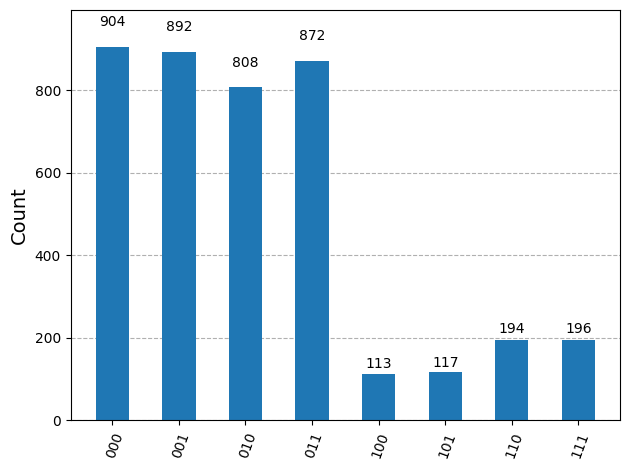

In [19]:
plot_histogram(result[0].data.c.get_counts())

Qiskitのビット配列は右端が0なので、Bobのビット(qubit 2)は左端です。Bobのビットの結果のみ抜き出します。

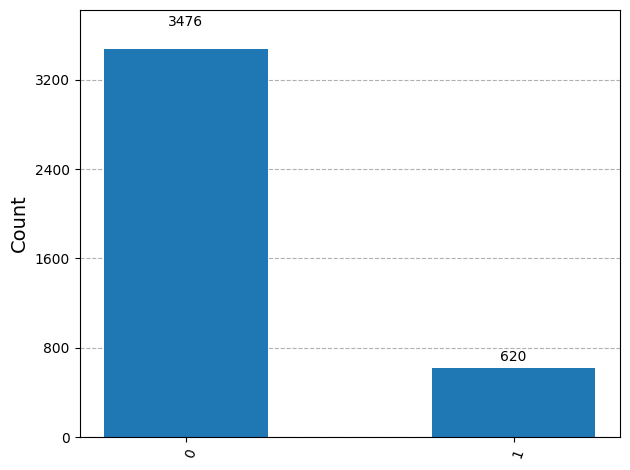

In [20]:
from qiskit.result import marginal_counts
bobs_qubit = 2
bobs_counts = marginal_counts(result[0].data.c.get_counts(), [bobs_qubit])
plot_histogram(bobs_counts)

## 演習

量子テレポーテーション回路を自分で組んで表示してみましょう。<br>
今回は、未知の量子状態をUゲートを使って、ランダムな角度で作ってみましょう。<br>
Bobに未知の量子状態が転送されたことを確認するために、最後にBobの量子ビットにUの逆行列を適用して、シミュレーターで実験し、測定結果が0になることを確認しましょう。

時間に余裕がある方は、実デバイスでも上記の実験を行ってみましょう。

参考：[Uゲート](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.UGate) は任意の角度の回転ゲートです。

In [21]:
np.random.seed(42) #乱数のシードを設定

# ランダムな角度を3つ作成
theta = np.random.uniform(0.0, 1.0) * np.pi     #from 0 to pi
varphi = np.random.uniform(0.0, 2.0) * np.pi    #from 0 to 2*pi
lamda = np.random.uniform(0.0, 2.0) * np.pi     #from 0 to 2*pi

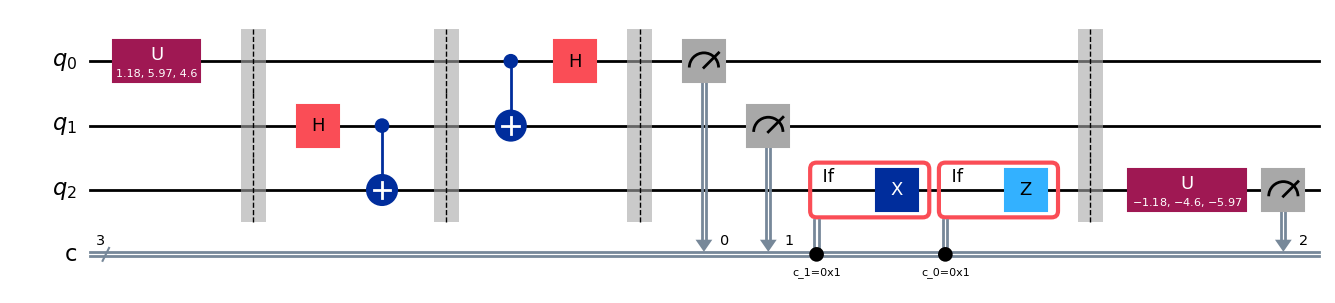

In [22]:
# 3量子ビット回路を用意
qc = QuantumCircuit(3,3)   

# Aliceのもつ未知の量子状態ψをUゲートで作ります。
qc.u(theta, varphi, lamda, 0)
qc.barrier()    #回路を見やすくするために入れます

# 量子もつれを作ります
##コードを記入してください##
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# AliceがCNOTとHでψと自分のEPRペアをエンタングルさせ測定します。
##コードを記入してください##
qc.cx(0, 1)
qc.h(0)
qc.barrier()

qc.measure(0, 0)
qc.measure(1, 1)

#Aliceが測定結果をBobに送り、Bobが結果に合わせて操作します
##コードを記入してください##
with qc.if_test((1, 1)):
    qc.x(2)
with qc.if_test((0, 1)):
    qc.z(2)
qc.barrier()

# 逆Uゲートをかけて０が測定できるか確かめます 
qc.u(theta, varphi, lamda, 2).inverse()    
qc.measure(2, 2)

qc.draw(output="mpl")

{'001': 269, '010': 232, '011': 242, '000': 281}


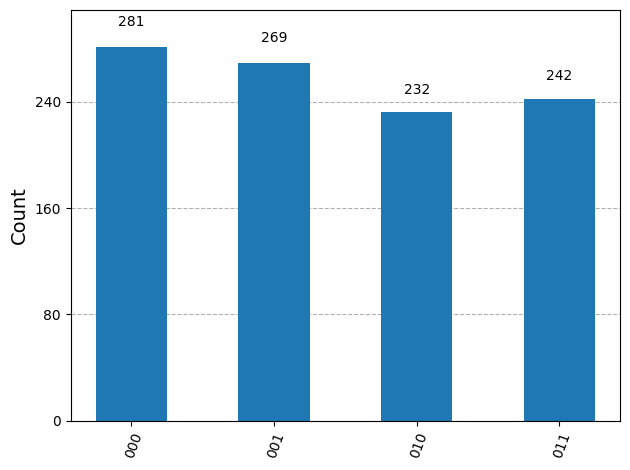

In [23]:
# シミュレーターで実験の際に使うコード例
backend = AerSimulator()

# Samplerで実行
sampler = SamplerV2(backend)
job = sampler.run([qc])
result = job.result()

#  測定された回数を表示
counts = result[0].data.c.get_counts()
print(counts)

# ヒストグラムで測定された確率をプロット
plot_histogram(counts)

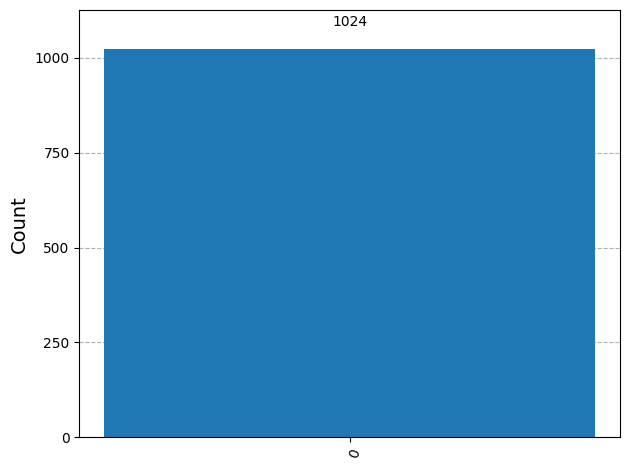

In [24]:
# Bobのビットの結果のみ抜き出します
bobs_qubit = 2
bobs_counts = marginal_counts(result[0].data.c.get_counts(), [bobs_qubit])
plot_histogram(bobs_counts)

In [25]:
import qiskit
qiskit.__version__

'2.2.0'